# Plane-wave-domain acoustic wave propagation
#### **Kristian Torres** <br><small>University of Alberta, Halliburton</small>
The plane-wave domain (PWD) is a simultaneous source approach for efficient acoustic wave propagation that can be used to reduce the computational burden of wave-equation based seismic inversion techniques such as FWI and RTM. 

The plane-wave source can be written as
\begin{equation}\tag{1}
f = \sum_{x_s} f(x_s, t - \Delta t)
\end{equation}
where $\Delta t$ is the time delay function applied at each shot location $x_s$. I express the time delay as a function of the ray parameter $p$ [s/km] and the source location $x_s$:
\begin{equation}\tag{2}
\Delta t(p, x_s) = p(x_s - x_0),
\end{equation}
with $x_0$ as the plane-wave origin.

In [1]:
import os
import multiprocessing

import matplotlib as mpl
import matplotlib.pyplot as plt

# Setup working directory
pwd_wd = os.path.abspath(os.getcwd())
os.chdir(pwd_wd)
print(f"Working directory: {pwd_wd}")

# Set OpenMP variable with number of physical cores
os.environ['DEVITO_LANGUAGE']='openmp'
os.environ['OMP_NUM_THREADS']= f'{multiprocessing.cpu_count()//2}'

Working directory: /home/torresba/devito_playground/plane_wave


Operator `initdamp` ran in 0.01 s


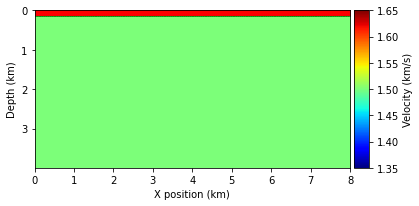

In [2]:
import numpy as np

from examples.seismic.model import SeismicModel
from examples.seismic import plot_velocity
from examples.seismic import AcquisitionGeometry

# Physical model dimensions
nx = 801 #383
nz = 400 #131

# Read model from binary file
#vp = np.load(os.path.join(pwd_wd, f'marmousi_vp_{nx}x{nz}.npy'))

# Or play with homogeneous model
vp = np.ones((nx,nz), dtype='float32')*1.5

# Model config
space_order = 4
origin = (0.,0.)
spacing=(10.,10.)
nbl = 300
model = SeismicModel(space_order=space_order, vp=vp, origin=origin, shape=(nx,nz), spacing=spacing,
                        nbl=nbl, grid=None)

#==================
# Plane-wave source
#==================
# Acquisition config
nshots = nx + 2*nbl #shots outside the physical domain
nreceivers = nx
t0 = 0.
tn = 8000.  # Simulation last tn ms
f0 = 0.020  # Source peak frequency is f0 kHz

# Define acquisition geometry 
src_coordinates = np.empty((nshots, 2))
src_coordinates[:, 0] = np.linspace(-nbl*spacing[0], model.domain_size[0]+nbl*spacing[0], num=nshots)
src_coordinates[:, 1] = 30.  # Depth is 30m

# Define acquisition geometry: receivers
rec_coordinates = np.empty((nreceivers, 2))
rec_coordinates[:, 0] = np.linspace(0, model.domain_size[0], num=nreceivers)
rec_coordinates[:, 1] = 30.

# Initialize dummy geometry
geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, t0, tn, f0=.010, t0w=0., src_type='Ricker')

plot_velocity(model, source=src_coordinates, receiver=rec_coordinates)

For plane wave propagation with differents ray parameters, I update the source data of the dummy geometry by calculating the time shifts using equation (2) above.

In [3]:
p = 0.2 # ray parameter in s/km

# Cases for positive and negative ray parameter
if p>=0.:
    x0 = geometry.src_positions[0,0]
else:
    x0 = geometry.src_positions[-1,0]

# Devito does not let me change src data in-place
src = geometry.src

def ricker_wavelet(time_values, f0, t0, a=1):
    r = (np.pi * f0 * (time_values - t0))
    return a * (1-2.*r**2)*np.exp(-r**2)

# Populate source data with time-delays
for i in range(nshots):
    delta_t = p*(geometry.src_positions[i,0] - x0) # eq (2)
    src.data[:, i] = ricker_wavelet(geometry.time_axis.time_values, geometry.f0, 1/geometry.f0 + delta_t) 

Re-initializing damp profile from mask to damp
Model has to be created with `bcs="damp"`for this WaveSolver
Operator `initdamp` ran in 0.01 s
Operator `Forward` ran in 1.97 s


Text(0.5, 1.0, 'p=0 s/km')

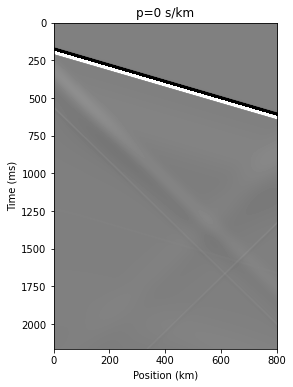

In [4]:
# Compute synthetic data with forward operator 
from examples.seismic.acoustic import AcousticWaveSolver

solver = AcousticWaveSolver(model, geometry, space_order=space_order)
d, wvfld, _ = solver.forward(vp=model.vp, src=src, save=True)

# Plot plane-wave gather
scale = np.percentile(d.data, 99.1)
fig, ax = plt.subplots(1,1,figsize=(4,6))
ax.imshow(d.data, vmin=-scale, vmax=scale, cmap='gray', aspect='auto')
ax.set_xlabel('Position (km)')
ax.set_ylabel('Time (ms)')
ax.set_title(f'p={p} s/km')

Even with a thick absourbing boundary layer, I still get artifacts at the boundaries. The following shows the source wavefield propagation.

In [5]:
import matplotlib.animation
from IPython.display import HTML

mpl.rcParams['animation.embed_limit'] = 2**128

params = {"ytick.color" : "#777",
          "xtick.color" : "#777",
          "axes.labelcolor" : "#777",
          "axes.edgecolor" : "#777"}
plt.rcParams.update(params)

ds = 50 #wavefield steps
snaps0 = wvfld.data[::ds,:,:]

pmin = np.percentile(snaps0, [99.4])
alpha = 0.2
cmap='gray'

fig, ax = plt.subplots(1,1, figsize=(6,4))
im0 = ax.imshow(snaps0[0,:,:].T, cmap=cmap, interpolation='none', vmin=-pmin, vmax=pmin, aspect='auto')


ax.plot([model.nbl, model.vp.shape[0]-model.nbl], [model.nbl, model.nbl], 'k', alpha=alpha) # up
ax.plot([model.nbl, model.vp.shape[0]-model.nbl], [model.vp.shape[1]-model.nbl, model.vp.shape[1]-model.nbl], 'k', alpha=alpha) # down
ax.plot([model.nbl, model.nbl], [(model.vp.shape[1]-model.nbl), model.nbl], 'k', alpha=alpha) # left
ax.plot([model.vp.shape[0]-model.nbl, model.vp.shape[0]-model.nbl], [(model.vp.shape[1]-model.nbl), model.nbl], 'k', alpha=alpha) # right
ax.set_xlabel('x (gridpoint)')
ax.set_ylabel('z (gridpoint)')

ax.set_title('(a) Source wavefield}')

plt.tight_layout()
plt.close()

def animate(i):
    im0.set_data(snaps0[i, :,:].T)

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=snaps0.shape[0])

HTML(ani.to_jshtml())

To get rid of some spurious reflections I can apply a cosine taper to the source amplitude outside of the physical domain.

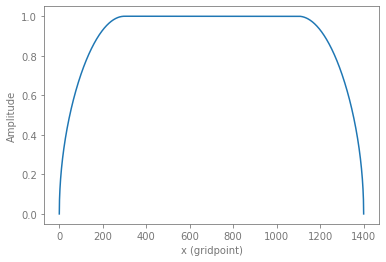

In [6]:
def cosine_taper(exp=0.5, nbl=300, plot=True):
    amplitude = np.ones(nshots, dtype='float32')
    
    for i in range(nbl):
        amplitude[i] = np.cos(((i-nbl)/nbl)*0.5*np.pi)**exp
    for i in range(nshots-nbl, nshots):
        amplitude[i] = np.cos(((i-(nshots-nbl-1))/nbl)*0.5*np.pi)**exp    
    
    if plot:
        plt.plot(amplitude)
        plt.xlabel('x (gridpoint)')
        plt.ylabel('Amplitude')
    return amplitude 

amplitude = cosine_taper(exp=0.5)

Now let's try the forward plane wave propagation with the tapered sources.

Operator `Forward` ran in 1.49 s


Text(0.5, 1.0, 'Tapered')

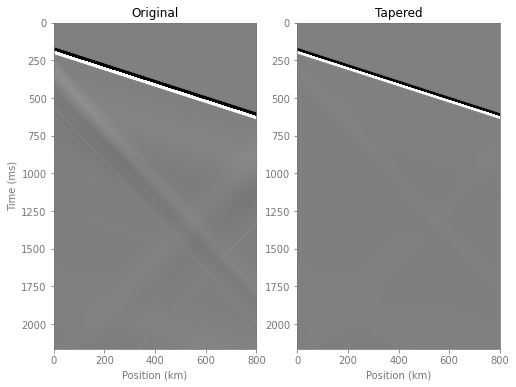

In [7]:
src = geometry.src

for i in range(nshots):
    delta_t = p*(geometry.src_positions[i,0] - x0)
    src.data[:, i] = ricker_wavelet(geometry.time_axis.time_values, geometry.f0, 1/geometry.f0 + delta_t, a=amplitude[i]) 

d_taper, _, _ = solver.forward(vp=model.vp, src=src)

# Plot plane-wave gathers comparison
fig, ax = plt.subplots(1,2, figsize=(8,6))
# First subplot
ax[0].imshow(d.data, vmin=-scale, vmax=scale, cmap='gray', aspect='auto')
ax[0].set_xlabel('Position (km)')
ax[0].set_ylabel('Time (ms)')
ax[0].set_title('Original')
# Second subplot
scale = np.percentile(d_taper.data, 99.3)
ax[1].imshow(d_taper.data, vmin=-scale, vmax=scale, cmap='gray', aspect='auto')
ax[1].set_xlabel('Position (km)')
ax[1].set_title('Tapered')

Text(0.5, 1.0, 'Tapered')

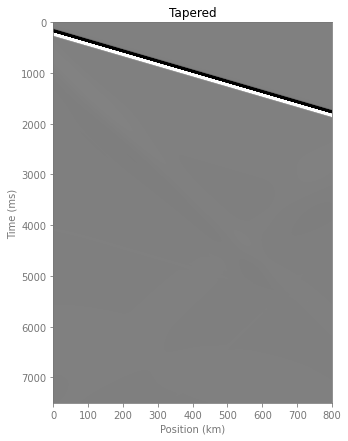

In [8]:
# The following is to plot as if x0 was at the origin
def find_nearest(time_axis, value):
    idx = (np.abs(time_axis-value)).argmin()
    return time_axis[idx], idx

init_src_coord = np.where(geometry.src_positions==0.)[0]
init_delta_t = p*(geometry.src_positions[init_src_coord,0] - x0) - 1/geometry.f0

init_t, idx = find_nearest(geometry.time_axis.time_values, init_delta_t)

extent = [0, geometry.nrec, tn - init_t, t0]

fig, ax = plt.subplots(1,1,figsize=(5,7))
scale = np.percentile(d_taper.data, 99.3)
ax.imshow(d_taper.data[idx:,:], aspect='auto', cmap='gray', vmin=-scale, vmax=scale, extent=extent)
ax.set_xlabel('Position (km)')
ax.set_ylabel('Time (ms)')
ax.set_title('Tapered')

Put everything together in a function. The forward opeartor can handle an array of ray parameters.

Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 1.55 s
Operator `Forward` ran in 1.60 s
Operator `Forward` ran in 1.55 s
Operator `Forward` ran in 1.64 s


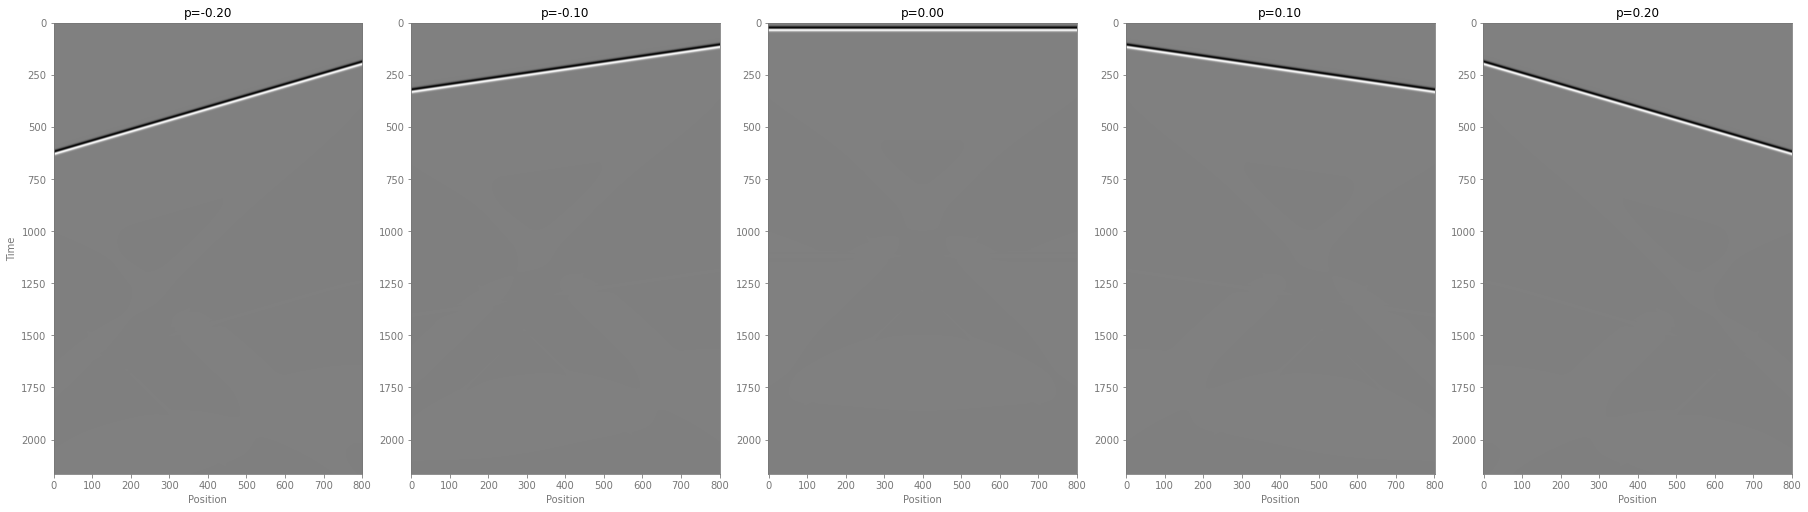

In [9]:
from pw_solver import PlaneWaveSolver

nump = 5 # total number of ray parameters
p = np.linspace(-0.2, 0.2, num=nump)
pwsolver = PlaneWaveSolver(model, geometry, p=p, space_order=space_order)

shots = pwsolver.forward(vp=model.vp)

axd = plt.figure(figsize=(5*nump,7), constrained_layout=True).subplot_mosaic(
    """
    ABCDE
    """
)

for j, letter in enumerate(sorted(axd)):
    scale = np.percentile(shots[j].data, 100)
    axd[letter].imshow(shots[j].data, aspect='auto', cmap='gray', vmin=-scale, vmax=scale)
    axd[letter].set_title(f'p={p[j]:.2f}')
    axd[letter].set_xlabel('Position')
    if letter == 'A':
        axd[letter].set_ylabel('Time')

## Marmousi example

Operator `initdamp` ran in 0.01 s
Re-initializing damp profile from mask to damp
Model has to be created with `bcs="damp"`for this WaveSolver
Operator `initdamp` ran in 0.01 s
Operator `Forward` ran in 4.17 s
Operator `Forward` ran in 4.79 s
Operator `Forward` ran in 4.88 s
Operator `Forward` ran in 4.94 s
Operator `Forward` ran in 4.94 s


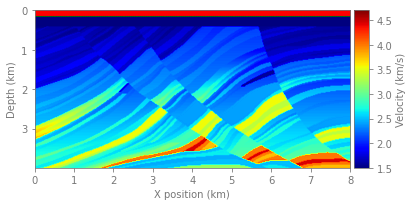

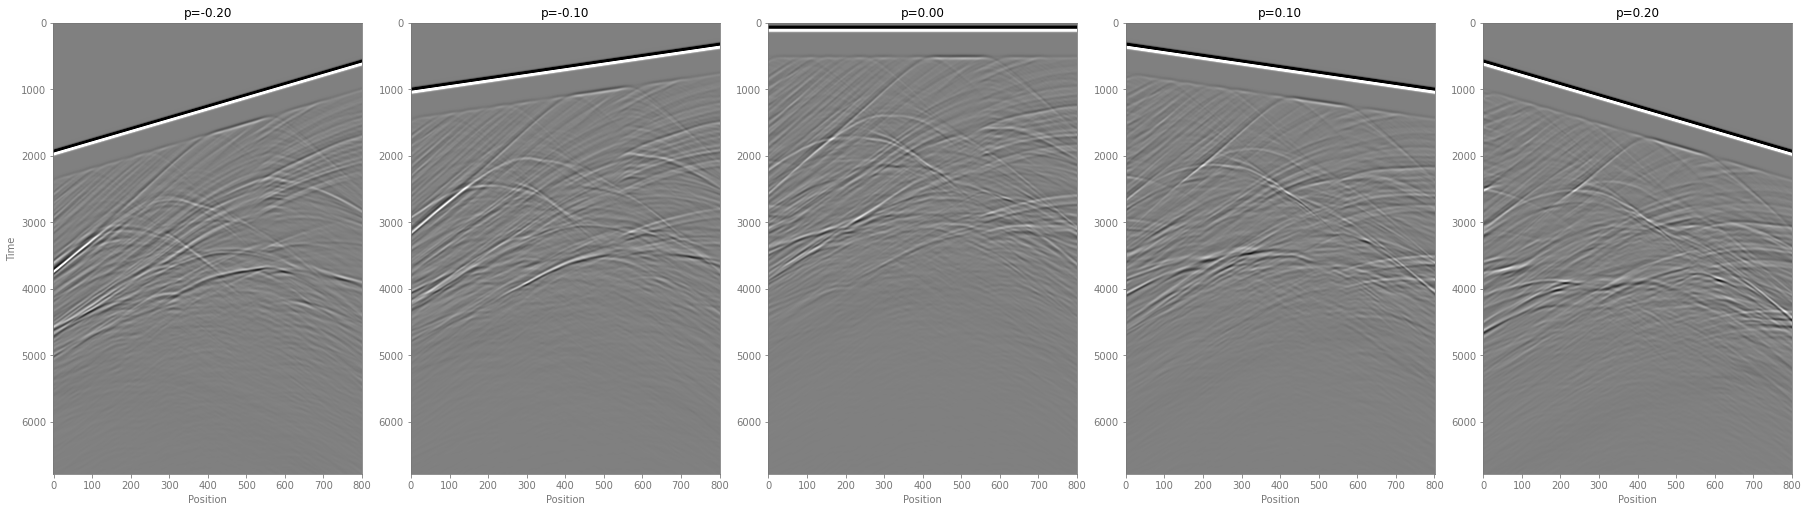

In [10]:
vp = np.load(os.path.join(pwd_wd, f'marmousi_vp_{nx}x{nz}.npy'))

model = SeismicModel(space_order=space_order, vp=vp, origin=origin, shape=(nx,nz), spacing=spacing,
                        nbl=nbl, grid=None)

geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, t0, tn, f0=.010, t0w=0., src_type='Ricker')

pwsolver = PlaneWaveSolver(model, geometry, p=p, space_order=space_order)

shots = pwsolver.forward(vp=model.vp)


# Plots
plot_velocity(model, source=src_coordinates, receiver=rec_coordinates)

axd = plt.figure(figsize=(5*nump,7), constrained_layout=True).subplot_mosaic(
    """
    ABCDE
    """
)
for j, letter in enumerate(sorted(axd)):
    scale = np.percentile(shots[j].data, 99.5)
    axd[letter].imshow(shots[j].data, aspect='auto', cmap='gray', vmin=-scale, vmax=scale)
    axd[letter].set_title(f'p={p[j]:.2f}')
    axd[letter].set_xlabel('Position')
    if letter == 'A':
        axd[letter].set_ylabel('Time')
